# Graphing the data from Template_run_Auto.py

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import astropy.stats
import math

In [262]:
os.getcwd()
test_title = 'individual_main_agn_above_0.1' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs'
agn_sed = [22]
id_key = 'only_agn' # normal, high or low
use_galaxy_templates = True
params = {}
params["Z_STEP"] = 0.05

#opening ZFOURGE data
id_key_dict = {
    'normal': f'inputs/alternate_catalogues/{field}.normal.cat',
    'fraction0.0to0.1': f'inputs/alternate_catalogues/{field}.fraction.bin0.0to0.1.cat',
    'fraction0.1to0.2': f'inputs/alternate_catalogues/{field}.fraction.bin0.1to0.2.cat',
    'fraction0.2to0.3': f'inputs/alternate_catalogues/{field}.fraction.bin0.2to0.3.cat',
    'fraction0.3to0.4': f'inputs/alternate_catalogues/{field}.fraction.bin0.3to0.4.cat',
    'fraction0.4to0.5': f'inputs/alternate_catalogues/{field}.fraction.bin0.4to0.5.cat',
    'ir_agn': f'inputs/alternate_catalogues/{field}.ir_agn.cat',
    'radio_agn': f'inputs/alternate_catalogues/{field}.radio_agn.cat',
    'xray_agn': f'inputs/alternate_catalogues/{field}.xray_agn.cat',
    'only_agn_0.4': f'inputs/alternate_catalogues/{field}.only_agn_above_0.4.cat',
    'only_agn_0.5': f'inputs/alternate_catalogues/{field}.only_agn_above_0.5.cat',
    'lacy': f'inputs/alternate_catalogues/{field}.lacy_wedge.cat',
    'donley': f'inputs/alternate_catalogues/{field}.donley_wedge.cat',
    'useflag': f'inputs/alternate_catalogues/{field}.useflag.cat'
}

main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
main_cat.to_csv('inputs/eazy_test.cat', index=False) # create a new catalogue, allows for change to be made in this cell

#opening test data
output_location = 'G:/honours/outputs'

#Setting up the main catalogue
main = pd.read_csv('inputs/eazy_test.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
headers = pd.read_csv('inputs/eazy_test.cat', sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers
agn_per_dir = f'inputs/{field}_agn_frac.txt' # file with AGN fractions for each object, prepared in catalogue_prepare.ipynb
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

has_fraction = 'bayes.agn.fracAGN' in main.columns
if not has_fraction:
    main = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object

agn_dir = 'templates/hlsp_agnsedatlas_rest/' # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)

# Loading values that are present in catalog, done at the end of EAZY_test.py
columns_to_drop = ['id', 'phot_redshift', 'chi2']
spec_data = pd.read_csv(f'{output_location}/{field}/spec_data.csv')

reindex_list = list(main['id'])
reindex_val = [x - 1 for x in reindex_list] # cat is indexed from 1, not 0
reindex_sel = spec_data['id'].isin(list(reindex_val))
spec_data = spec_data[reindex_sel].reset_index(drop=True)

filter_data = pd.read_csv(f'{output_location}/{field}/filter_data.csv')
flux_data = pd.read_csv(f'{output_location}/{field}/flux_data.csv')

filter_error = flux_data.filter(regex='^e_')
filter_error = filter_error[reindex_sel].reset_index(drop=True)
filter_flux = flux_data.filter(regex='^f_')
filter_flux = filter_flux[reindex_sel].reset_index(drop=True)

In [263]:
#Load Test Data
individual_df = pd.read_csv(f'{output_location}/{field}/{test_title}/induvidual_data_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.csv')

In [264]:
# to maintain consitency with EAZY Test, we need to load the data in the same way
class self_load:
    def __init__(self, idx, ZSPEC, ZBEST, fnu, efnu, efmodel, pivot, zbest):
        self.idx = main['id'].index
        self.ZSPEC = spec_data['zspec']
        self.fnu = filter_flux
        self.efnu = filter_error
        self.fmodel = individual_df.drop(columns=columns_to_drop)
        self.pivot = filter_data['pivot']
        self.zbest = individual_df['phot_redshift']

self=self_load(0,0,0,0,0,0,0,0)


In [265]:
all_zphot_zspec = pd.DataFrame(
    {'id': self.idx, 'zspec': list(self.ZSPEC), 'zphot': self.zbest, 'agn_fraction': main['bayes.agn.fracAGN']})

## Loading Done, just copy the graphs below

In [266]:
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zspec'] > 0.005]  #setting minimums for the redshifts
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zphot'] > 0.02]
all_zphot_zspec['compare'] = (all_zphot_zspec['zphot'] - all_zphot_zspec['zspec']) / (1 + all_zphot_zspec['zspec'])

In [267]:
#Colour Plot with each template (maybe a range around them), and then each object plotted, to see how well these templates cover the objects, in the observed frame

colours = ['U', 'V', 'J3']  # colours to be used, dictates loops and filter responses
columns = ['id', 'agn_fraction', 'red_diff'] + colours  # columns to be used in the dataframe
used_colours = pd.DataFrame(columns=columns)

for i in range(len(colours)):
    used_colours[colours[i]] = main[f'f_{colours[i]}']

used_colours['id'] = main['id']
used_colours['agn_fraction'] = main['bayes.agn.fracAGN']
used_colours['red_diff'] = all_zphot_zspec['compare']

no_negative_mask = ~used_colours[colours].lt(0).any(axis=1)
used_colours = used_colours[no_negative_mask]  #remove -99 values


# UVJ colours
def axis_math(colour1, colour2):
    return 25 - 2.5 * np.log10(colour1 / colour2)


used_colours['UV'] = axis_math(used_colours[colours[0]], used_colours[colours[1]])
used_colours['VJ'] = axis_math(used_colours[colours[1]], used_colours[colours[2]])

#Template colours

cdfs_filters = {'U': 3749, 'V': 5919, 'J3': 12802}


def template_colour_redshift(template, redshift):
    """
    Function to calculate the UVJ colours of a template at a given redshift
    template: template number
    redshift: redshift of the object
    """

    template_data_pre = pd.read_csv(f'{agn_dir}{agn_temp_all[template]}', sep=' ', header=None)

    template_data_shifted = pd.DataFrame(columns=['wavelength', 'flux'])
    template_data_shifted['wavelength'] = (redshift * template_data_pre[0]) + template_data_pre[
        0]  #redshifting the template
    template_data_shifted['flux'] = template_data_pre[1]

    temp_filt_flux_all = pd.DataFrame(columns=[colours])

    for j in range(len(colours)):
        min_location = abs(template_data_shifted['wavelength'] - cdfs_filters[colours[j]]).idxmin()
        temp_filt_flux = template_data_shifted['flux'][min_location]
        temp_filt_flux_all[colours[j]] = [temp_filt_flux]

    return temp_filt_flux_all

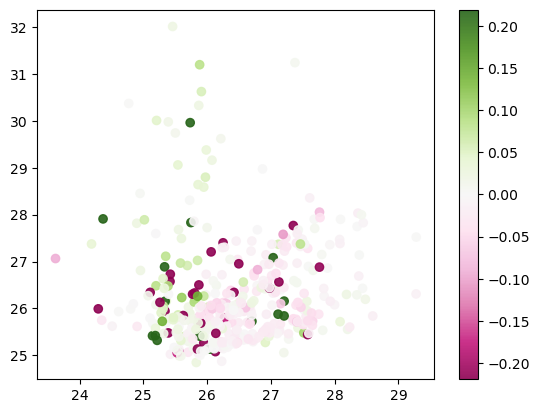

In [268]:
# UVJ plot
import matplotlib.colors as colors

plt.clf()
three_sig_limit = used_colours['red_diff'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(used_colours['VJ'], used_colours['UV'], c=used_colours['red_diff'], cmap='PiYG', norm=norm, alpha=0.9)
#plt.xlim(0, 2.5)
#plt.ylim(0, 2.5)
plt.colorbar()

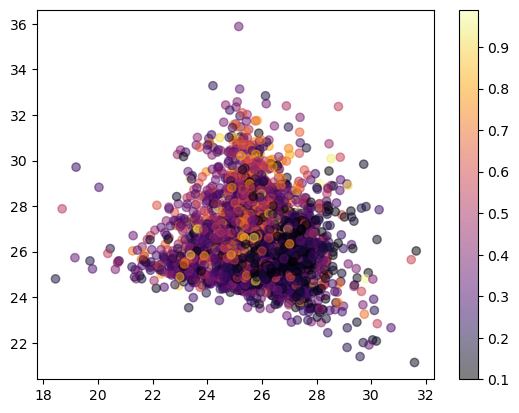

In [269]:

plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('UVJ Plot with Redshift Difference')
# UVJ plot
plt.clf()
plt.scatter(used_colours['VJ'], used_colours['UV'], c=used_colours['agn_fraction'], cmap='inferno', alpha=0.5)
#plt.xlim(0, 2.5)
#plt.ylim(0, 2.5)
plt.colorbar()

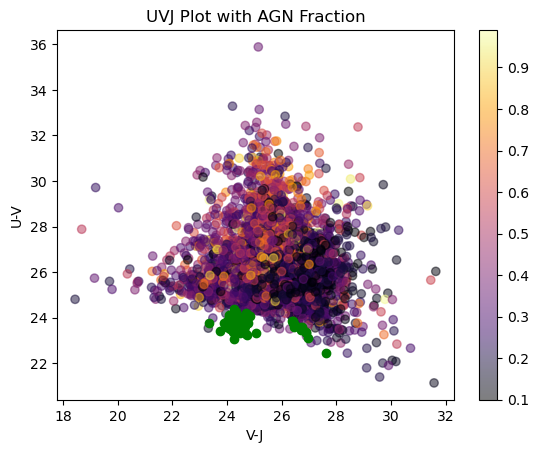

In [270]:

plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('UVJ Plot with AGN Fraction')
# UVJ plot
plt.clf()
plt.scatter(used_colours['VJ'], used_colours['UV'], c=used_colours['agn_fraction'], cmap='inferno', alpha=0.5)
#plt.xlim(0, 2.5)
#plt.ylim(0, 2.5)
plt.colorbar()

plt.xlabel('V-J')
plt.ylabel('U-V')
plt.title('UVJ Plot with AGN Fraction')

templates_graph = agn_sed  # templates to be plotted
redshift_graph = np.linspace(0, 5, 50)  # redshifts to be plotted
for i in range(len(templates_graph)):
    for j in range(len(redshift_graph)):
        temp_redshift = template_colour_redshift(templates_graph[i], redshift_graph[j])
        temp_redshift.to_numpy()
        temp_redshift['y_axis'] = axis_math(temp_redshift['U'].values[0], temp_redshift['V'].values[0])
        temp_redshift['x_axis'] = axis_math(temp_redshift['V'].values[0], temp_redshift['J3'].values[0])
        plt.plot(temp_redshift['y_axis'], temp_redshift['x_axis'], marker='o', c='green')

Redshift
Plot
with AGN fraction

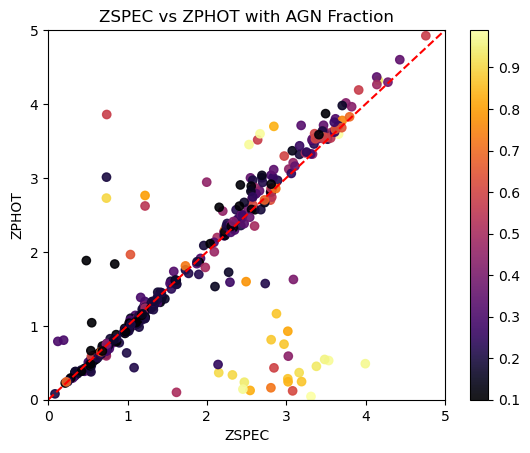

In [271]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['zphot'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 6], 'r--')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT')
plt.title('ZSPEC vs ZPHOT with AGN Fraction')
plt.colorbar()

RedShift
Difference
Vs
AGN
Fraction

Text(0.5, 1.0, 'Redshift Difference with AGN Fraction')

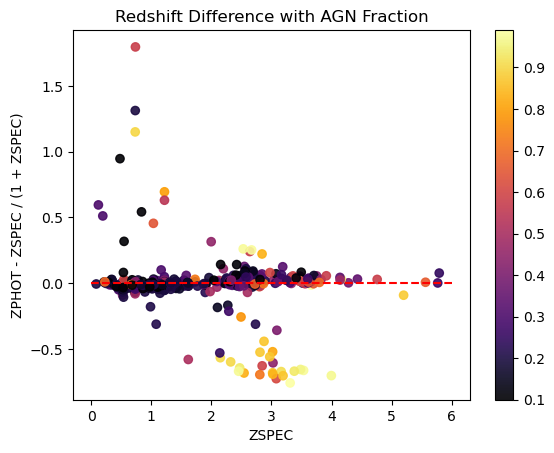

In [272]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with AGN Fraction')

Calculating
NMAD in bins

In [273]:
main['ZSPEC'] = self.ZSPEC
main['ZPHOT'] = self.zbest  # adding zspec and zphot to the agn_frac df
main['chi2'] = individual_df['chi2']  # adding chi2/N to the main df

#sort main df by zspec
main_red = main[main['ZSPEC'] > 0]  # filter
main_red = main_red[main_red['ZPHOT'] > 0.02]  # filter
main_red = main_red[main_red['ZSPEC'] <= 6]  # filter
main_red = main_red.sort_values(by='ZSPEC')  # sort

#sort main df by agn fraction
main_agn = main_red.dropna(subset=['bayes.agn.fracAGN'])  # filter
main_agn = main_agn.sort_values(by='bayes.agn.fracAGN')  # sort

#total NMAD
zspec_nmad = np.array(main_red['ZSPEC'])
zphot_nmad = np.array(main_red['ZPHOT'])
dz = (zphot_nmad - zspec_nmad) / (1 + zspec_nmad)
total_nmad = astropy.stats.mad_std(dz)
print(f'Total NMAD: {total_nmad}')

#outliers
spec_count = len(dz)
catastrophic_limit = 0.15  # catastrophic_limit in eazy code
outliers = np.abs(dz) >= catastrophic_limit
outliers_count = sum(outliers)
print(f'Total Outliers:{outliers_count}')

no_of_bins = 15  # no. of bins

Total NMAD: 0.03107754290857581
Total Outliers:48


Counts: [ 1  1  1  3  9  7 44 63 42 71 23 48 68 47  6]
Total: 434
NMAD: [nan, nan, nan, 0.0011352009072310401, 0.023909913201669464, 0.01302582216438831, 0.02980451677862858, 0.019975009605798122, 0.014271308706047705, 0.018263358752375426, 0.02519547106762529, 0.04004453325409665, 0.07462466785845868, 0.02714293781054846, 0.031902915039994616]
Outliers: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045454545454545456, 0.047619047619047616, 0.07142857142857142, 0.04225352112676056, 0.043478260869565216, 0.1875, 0.27941176470588236, 0.10638297872340426, 0.0]
Fits: [nan, nan, nan, 36.480258, 23.903758, 23.375874500000002, 28.34873, 29.0443905, 22.17351, 24.603682, 25.709698, 43.668312, 35.148952, 50.607723, 41.555374]


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

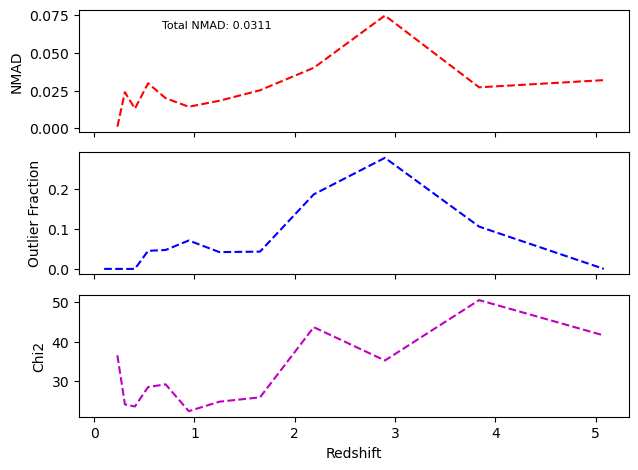

In [274]:
logbins_start = np.log10(min(main_red['ZSPEC']))  # using logarithmic bins
logbins_end = np.log10(max(main_red['ZSPEC'])) + 1e-10  # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins + 1)
counts_red, bins_red = np.histogram(main_red['ZSPEC'], bins=logbins)
print(f'Counts: {counts_red}')
print(f'Total: {len(main_red["ZSPEC"])}')
bin_centers_red = (np.array(bins_red[:-1]) + np.array(bins_red[1:])) / 2

last_val = 0  # last val is the first value within a bin (say object 2334), while new val is the last
nmad_red_val = []
outlier_frac_red = []
chi2_red = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_red[bin_loop] - 1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_red_val.append(astropy.stats.mad_std(dz))  # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit
    bin_fraction = sum(outliers_bin) / counts_red[bin_loop]
    outlier_frac_red.append(bin_fraction)
    chi2_med = np.median(main_red['chi2'][last_val:new_val])  # chi2
    chi2_red.append(chi2_med)
    last_val = new_val + 1  # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_red_val}')
print(f'Outliers: {outlier_frac_red}')
print(f'Fits: {chi2_red}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_red, nmad_red_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center',
           verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_red, outlier_frac_red, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_red, chi2_red, 'm--')
ax[2].set_xlabel('Redshift')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

#plt.savefig(f'outputs/{field}/{test_title}/RED_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Counts: [110 115  44  46  20  18  18   7  13   7   8   2   7   8  11]
NMAD: [0.02532307587858944, 0.024528869365026514, 0.03165988825247251, 0.02549310591209787, 0.03213873316824543, 0.02283546956162117, 0.03837364159874021, 0.01499637759365555, 0.0330457791884831, 0.011061057488494693, 0.03603039754348257, 0.0, 0.30462128851485154, 0.057788460399110966, 0.04345362869881013]
Outliers: [0.5909090909090909, 0.591304347826087, 0.5681818181818182, 0.5434782608695652, 0.75, 0.6666666666666666, 0.7777777777777778, 0.42857142857142855, 0.6923076923076923, 0.14285714285714285, 0.5, 0.5, 0.8571428571428571, 0.875, 0.9090909090909091]
Fits: [29.432947, 24.973935, 32.033073, 27.855925, 33.50999, 43.46263, 36.37354, 39.9669455, 64.481307, 121.71661, 48.01959, 8.7658825, 37.306611000000004, 32.187378, 45.3288015]


<Figure size 640x480 with 0 Axes>

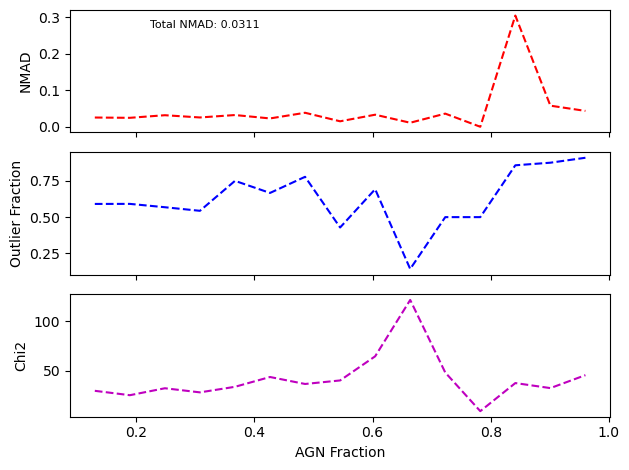

In [275]:

#NMAD against AGN fraction

counts_agn, bins_agn = np.histogram(main_agn['bayes.agn.fracAGN'], bins=no_of_bins)
print(f'Counts: {counts_agn}')
bin_centers_agn = (np.array(bins_agn[:-1]) + np.array(bins_agn[1:])) / 2

last_val = 0  # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
outlier_frac_agn = []
chi2_agn = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_agn[bin_loop] - 1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz))  # NMAD
    outliers_bin = np.abs(dz) >= 0.015  # outlier
    bin_fraction = sum(outliers_bin) / counts_agn[bin_loop]
    outlier_frac_agn.append(bin_fraction)
    chi2_med = np.median(main_agn['chi2'][last_val:new_val])  # chi2
    chi2_agn.append(chi2_med)
    last_val = new_val + 1  # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_agn_val}')
print(f'Outliers: {outlier_frac_agn}')
print(f'Fits: {chi2_agn}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_agn, nmad_agn_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center',
           verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_agn, outlier_frac_agn, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_agn, chi2_agn, 'm--')
ax[2].set_xlabel('AGN Fraction')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

#plt.savefig(f'outputs/{field}/{test_title}/AGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Redshift
Vs
AGN
Fraction

In [276]:
delta_z = (np.array(main_agn['ZPHOT']) - np.array(main_agn['ZSPEC'])) / (1 + np.array(main_agn['ZSPEC']))
red_agn_plot = pd.DataFrame(columns=['delta_z', 'agn_fraction'])
red_agn_plot['delta_z'] = delta_z
agn_fraction = main_agn['bayes.agn.fracAGN']
agn_fraction.index = range(len(agn_fraction))
red_agn_plot['agn_fraction'] = agn_fraction
red_agn_plot = red_agn_plot.sort_values(by=['agn_fraction'])
#red_agn_plot = red_agn_plot[abs(red_agn_plot['delta_z']) <= catastrophic_limit]

no_of_bins_red_agn = 30
bin_edges = pd.qcut(red_agn_plot['agn_fraction'], no_of_bins_red_agn)
bin_edges = bin_edges.cat.categories
red_agn_bins = np.zeros([no_of_bins_red_agn, 2])

for i in range(no_of_bins_red_agn):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = red_agn_plot[(red_agn_plot['agn_fraction'] >= min_loop) & (red_agn_plot['agn_fraction'] <= max_loop)]
    red_agn_bins[i, 0] = np.mean(bin_values['delta_z'])
    red_agn_bins[i, 1] = np.mean(bin_values['agn_fraction'])

Text(0.5, 1.0, 'Redshift vs AGN Fraction')

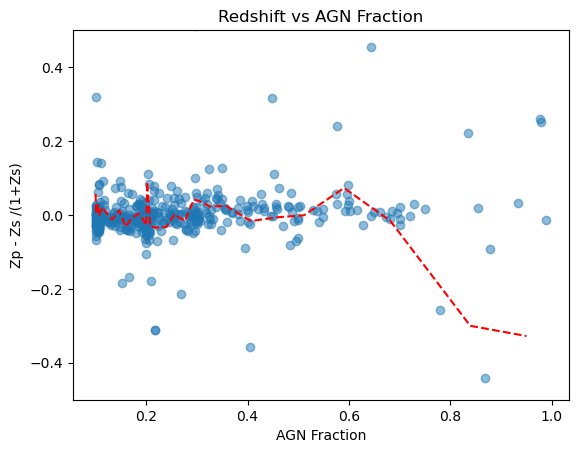

In [277]:
plt.clf()
plt.scatter(red_agn_plot['agn_fraction'], red_agn_plot['delta_z'], alpha=0.5)
plt.plot(red_agn_bins[:, 1], red_agn_bins[:, 0], 'r--')
plt.ylim(-0.5, 0.5)
plt.xlabel('AGN Fraction')
plt.ylabel('Zp - Zs /(1+Zs)')
plt.title('Redshift vs AGN Fraction')

Residuals

In [278]:
#limit the no of objects to those that are present in all bands, and have a positive redshift
flux_observed = []
flux_residual_objects = []

# Filter section
filter_attendance = 39 # can miss 1 filter and still be selected
for i in range(len(self.fnu)):
    if self.ZSPEC[i] < 0.001:
        continue # don't use objects with no redshift
    if sum(self.fnu[i] <= 0) > filter_attendance:
        continue # don't use objects where more than filter attendance filters are missing (eg. if one filter_attendance is 1, if one filter is missing it still goes forward, if two are missing it doesn't)
    else:
        flux_observed.append(self.fnu[i])
        flux_residual_objects.append(i)
flux_observed = np.array(flux_observed)

#find the residuals of the objects
flux_model = self.fmodel[flux_residual_objects]
error_observed = self.efnu[flux_residual_objects]
flux_residual = np.zeros_like(flux_observed)
residual_uncertainties = []
for row in range(len(flux_residual_objects)):
    residual_uncertainties.append(error_observed[row] / flux_observed[row])
    for col in range(flux_observed.shape[1]): #no. of bands
        if flux_observed[row,col] == -99: # if the flux is -99, it is not recorded and should not be shown as such
            flux_residual[row, col] = math.nan
        elif flux_model[row,col] == 0: # some models have no flux, this means they will be removed later
            flux_residual[row, col] = math.nan
        else:
            flux_residual[row,col] = (flux_observed[row,col] - flux_model[row,col]) / flux_observed[row,col]

#flux_residual = flux_residual[~np.isnan(flux_residual).any(axis=1)] # remove nan values
residual_uncertainties = np.array(residual_uncertainties)

#redshift the objects
object_redshifted = []
pivots = self.pivot
for i in range(len(flux_residual_objects)):
    im = flux_residual_objects[i]
    redshifted = pivots / (1 + self.ZSPEC[im])
    object_redshifted.append(redshifted)
object_redshifted = np.array(object_redshifted)

In [279]:
#plot the residuals
wavelength_flat = object_redshifted.flatten()
residual_flat = flux_residual.flatten()
uncertainties_flat = residual_uncertainties.flatten()

#binning
obj_per_bin = round(0.5 * sum(self.ZSPEC > 0.001)) #EAZY used 2000
res_sorted = pd.DataFrame({'wavelength':wavelength_flat, 'residual':residual_flat, 'uncertainties':uncertainties_flat})
res_sorted = res_sorted.sort_values(by='wavelength')
res_sorted = res_sorted.dropna(how='any') # remove nan
res_std = np.std(res_sorted['residual'])
res_sorted = res_sorted[abs(res_sorted['residual']) < 3 * res_std] # remove 3sig outliers
no_of_bins_res = np.ceil(len(res_sorted) // obj_per_bin)
res_sorted = res_sorted.reset_index(drop=True)
res_sorted_copy = res_sorted # not abs
res_sorted = abs(res_sorted)
res_bin = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", "Confidence"])
res_bin_copy = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", 'Confidence'])
for i in range(int(no_of_bins_res)):
    min_loop = i * obj_per_bin
    max_loop = ((i+1) * obj_per_bin)
    med_res = np.median(res_sorted['residual'][min_loop:max_loop])
    med_res_copy = np.median(res_sorted_copy['residual'][min_loop:max_loop]) # only the residuals should be affected by abs
    med_wave = np.median(res_sorted['wavelength'][min_loop:max_loop])
    med_unc = np.median(res_sorted['uncertainties'][min_loop:max_loop])
    confidence =  (50/68.2) * 1.2533 * (np.std(res_sorted_copy['residual'][min_loop:max_loop])/np.sqrt(obj_per_bin)) # want 50% confidence interval from standard error of the median
    res_bin.loc[i] = [med_res, med_wave, med_unc, confidence]
    res_bin_copy.loc[i] = [med_res_copy, med_wave, med_unc, confidence] # copy is not abs

<Figure size 640x480 with 0 Axes>

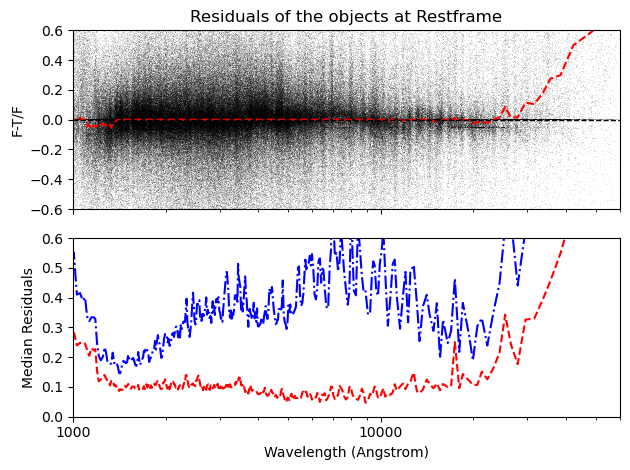

In [280]:
plt.clf()
fig, ax = plt.subplots(2, 1, sharex=True)
fig.gca().set_xscale('log')
fig.gca().xaxis.set_major_formatter('{x:.0f}')

ax[0].plot(wavelength_flat, residual_flat, 'k,', alpha=0.1)
ax[0].plot(res_bin_copy["Median Wavelength"], res_bin_copy["Median Residuals"], 'r')
ax[0].fill_between(res_bin_copy["Median Wavelength"],
                 res_bin_copy["Median Residuals"] - res_bin["Confidence"],
                 res_bin_copy["Median Residuals"] + res_bin["Confidence"], alpha=0.2, color='orange')
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
ax[0].set_ylim(-0.2, 0.2)
ax[0].set_xlim(1e3, 6e4)
ax[0].set_ylabel('F-T/F')
ax[0].set_title('Residuals of the objects at Restframe')

ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Residuals"], 'r', label='Absolute Residuals')
# ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Uncertainties"], 'b-.', label='Uncertainties')
ax[1].plot(res_bin["Median Wavelength"], res_bin["Confidence"], 'k-.', label='Confidence')
ax[1].set_ylim(0, 0.3)
ax[1].set_ylabel('Median Residuals')
ax[1].set_xlabel('Wavelength (Angstrom)')
ax[1].legend()

fig.tight_layout()

#plt.savefig(f'{output_location}/{field}/{test_title}/residuals_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()